In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ncon import ncon
from Initialization import Ising_Tc, initialize_Ising, impurity_Ising, initialize_Ising_mag
from loop_opt import normalize_tensor
from cft import cal_sdimension
from tqdm.auto import tqdm

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['font.size'] =28
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['figure.figsize'] = (8,8)

In [2]:
Ising_Tc

2.269185314213022

In [3]:
def initialize_Ising(T):
    beta = 1./T
    Ising=np.zeros((2,2,2,2))
    c=np.cosh(beta)
    s=np.sinh(beta)
    for i in range(2):
        for j in range(2):
            for k in range(2):
                for l in range(2):
                    if (i+j+k+l)==0:
                        Ising[i,j,k,l]=2*c*c
                    elif (i+j+k+l)==2:
                        Ising[i,j,k,l]=2*c*s
                    elif (i+j+k+l)==4:
                        Ising[i,j,k,l]=2*s*s
    return Ising

In [4]:
a = initialize_Ising(Ising_Tc)
a.shape

(2, 2, 2, 2)

### [S. Morita's slide](https://www.issp.u-tokyo.ac.jp/public/caqmp2019/slides/718S_Morita.pdf)
#### We use HOTRG for simplicity(might be easily extended to implement back-propagations). Using TNR scheme can reduce the computational cost to $O(\chi^6)$.
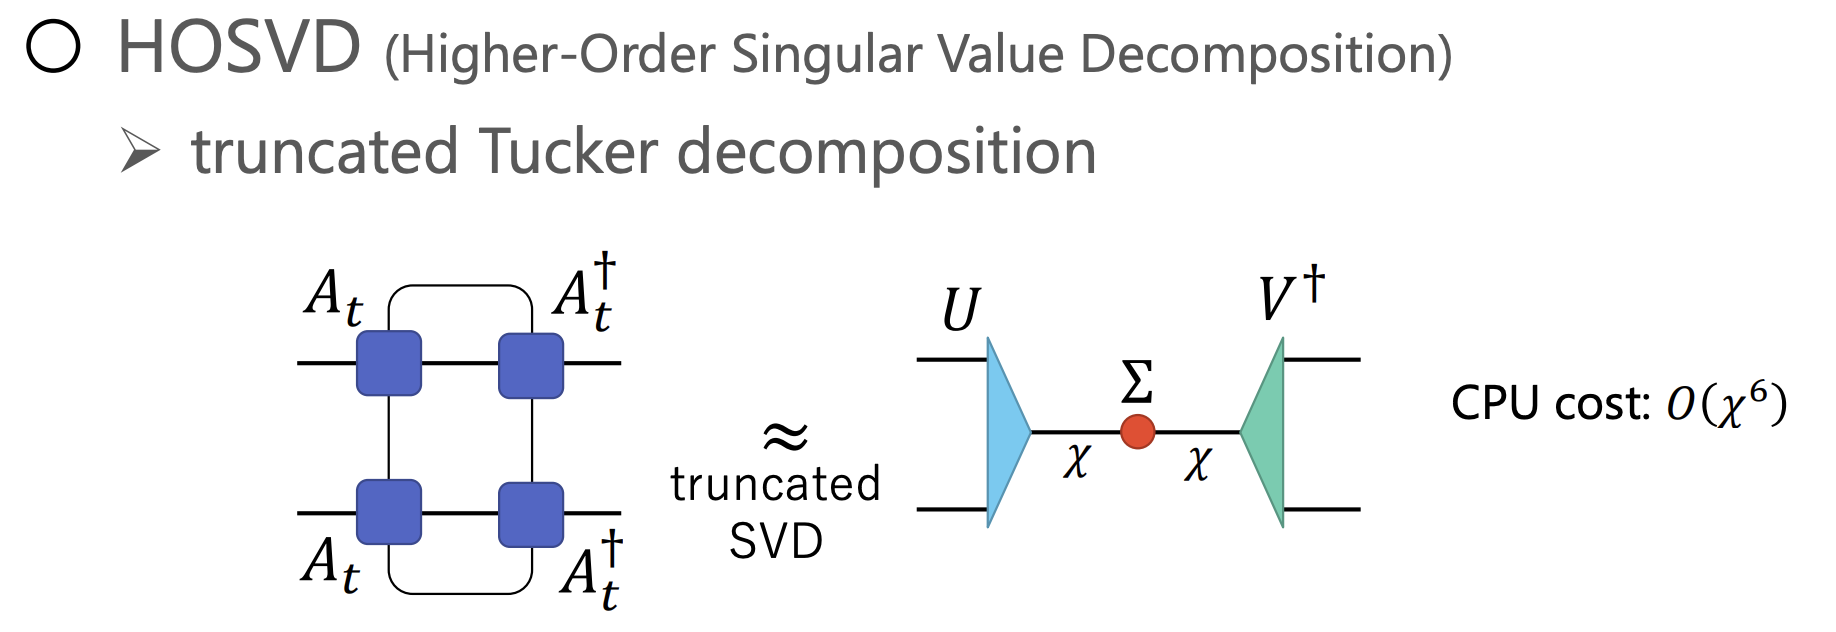

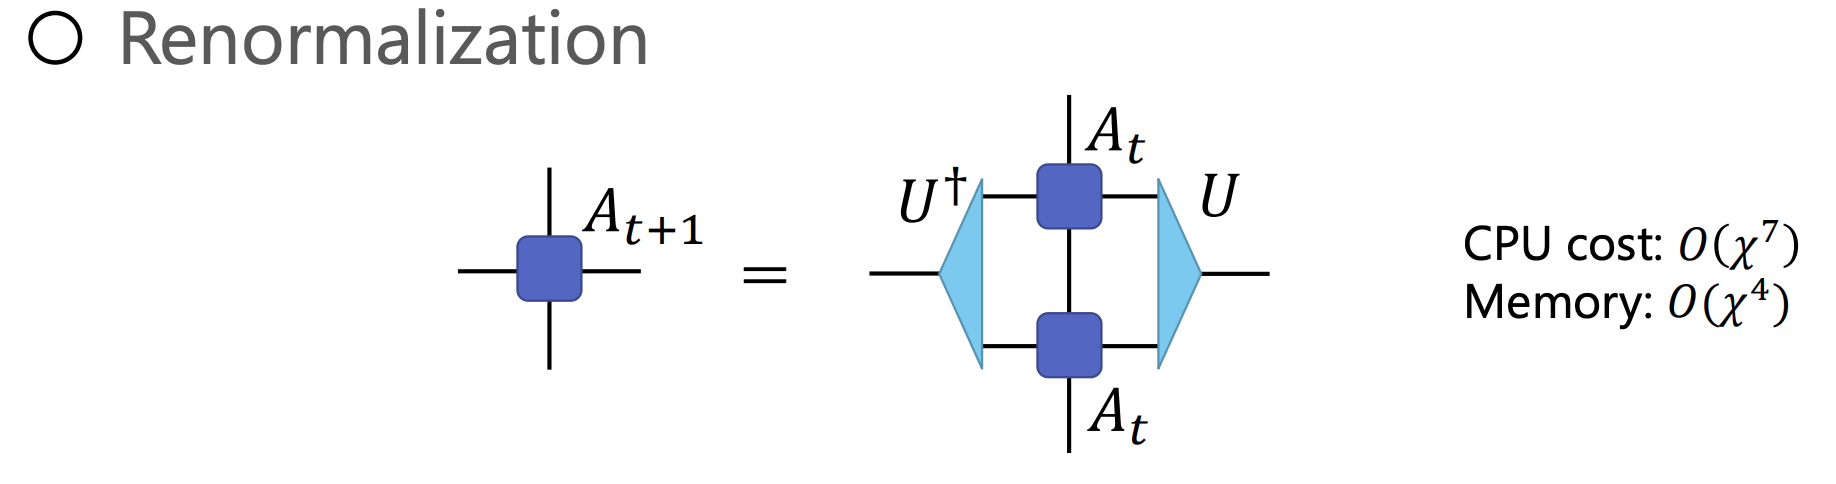

In [5]:
def trace_tensor(A):
    return np.einsum("ijij",A)

def find_U(A,χ,cutoff=1e-14):
    four_tensor = ncon([A,A,np.conj(A),np.conj(A)],([-1,2,1,5],[-2,5,3,4],[-3,2,1,6],[-4,6,3,4]))
    shape = four_tensor.shape
    tmp = four_tensor.reshape(shape[0]*shape[1],-1)
    u,s,vt = np.linalg.svd(tmp,hermitian=False)
    s = s[s>cutoff]
    χ_cut = min(len(s),χ)
    u = u[:,:χ_cut]
    return u.reshape(shape[0],shape[1],-1)

def contract_vertical(A,χ,cutoff=1e-14):
    u = find_U(A,χ,cutoff=cutoff)
    return ncon([A,A,u,np.conj(u)],([2,-2,4,1],[3,1,5,-4],[4,5,-3],[2,3,-1]))

def contract_horizontal(A,χ,cutoff=1e-14):
    return contract_vertical(A.transpose(1,2,3,0),χ,cutoff=cutoff).transpose(3,0,1,2)

def HOTRG_step(A,χ,cutoff=1e-14):
    A_new = contract_vertical(A,χ,cutoff=cutoff)
    A_new = contract_horizontal(A_new,χ,cutoff=cutoff)
    A_new,_,norm = normalize_tensor(A_new,A_new)
    return A_new, norm

def cal_lnz(T,h,χ,RG_step=20,return_list=False):
    lnz = 0
    area = 4
    A = initialize_Ising_mag(T,h)
    A_new,_,norm = normalize_tensor(A,A)
    lnz += np.log(norm)/area
    if return_list:
        lnz_list = [lnz] 
    for i in range(RG_step):
        A_new, norm = HOTRG_step(A_new,χ,cutoff=1e-12)
        area *= 4
        lnz += np.log(norm)/area
        if return_list:
            lnz_list.append(lnz)
    if return_list:
        return np.array(lnz_list)
    return lnz



In [6]:
lnz = 0
area = 4
a_new = initialize_Ising(Ising_Tc)
for i in range(10):
    a_new, norm = HOTRG_step(a_new,16,cutoff=1e-12)
    cft_data = cal_sdimension(a_new,a_new,norm)
    area *= 4
    lnz += np.log(norm)/area
    print("step: ",i+1,"\t L :", 2**(i+1))
    print(cft_data[1:3])
print(lnz)

step:  1 	 L : 2
[0.12892233 0.95215323]
step:  2 	 L : 4
[0.12583958 0.98738972]
step:  3 	 L : 8
[0.12520333 0.99704119]
step:  4 	 L : 16
[0.12505095 1.00125664]
step:  5 	 L : 32
[0.1249162  1.00750327]
step:  6 	 L : 64
[0.12447222 1.01731967]
step:  7 	 L : 128
[0.12328535 1.02868994]
step:  8 	 L : 256
[0.12064845 1.03832102]
step:  9 	 L : 512
[0.11491337 1.03816593]
step:  10 	 L : 1024
[0.1042925 1.0344208]
0.9296950350661907


## Impurity tensor 
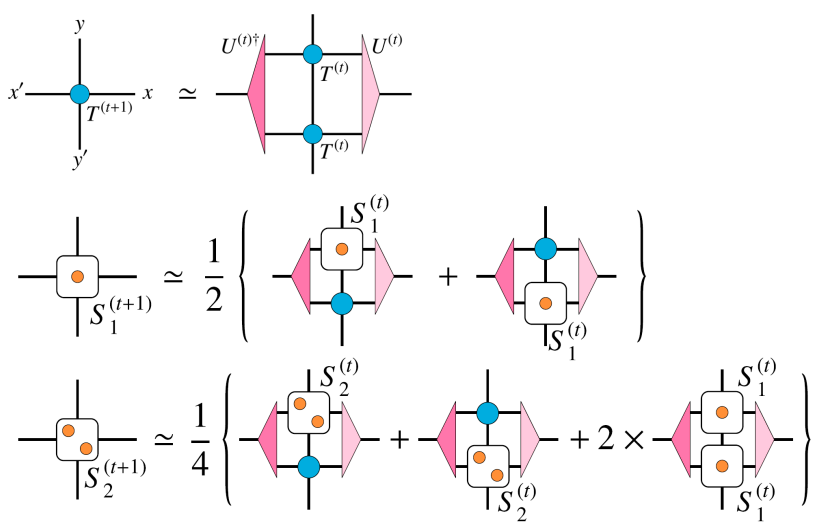

In [7]:
def contract_vertical_S(A,S,χ,cutoff=1e-14):
    u = find_U(A,χ,cutoff=cutoff)
    A_new = ncon([A,A,u,np.conj(u)],([2,-2,4,1],[3,1,5,-4],[4,5,-3],[2,3,-1]))
    S_up = ncon([A,S,u,np.conj(u)],([2,-2,4,1],[3,1,5,-4],[4,5,-3],[2,3,-1]))
    S_down = ncon([S,A,u,np.conj(u)],([2,-2,4,1],[3,1,5,-4],[4,5,-3],[2,3,-1]))
    return A_new, 0.5*(S_up+S_down)

def contract_horizontal_S(A,S,χ,cutoff=1e-14):
    A_new, S_new = contract_vertical_S(A.transpose(1,2,3,0),S.transpose(1,2,3,0),χ,cutoff=cutoff)
    return A_new.transpose(3,0,1,2), S_new.transpose(3,0,1,2)

def HOTRG_step_impurity(A,S,χ,cutoff=1e-14):
    A_new,S_new = contract_vertical_S(A,S,χ,cutoff=cutoff)
    A_new,S_new = contract_horizontal_S(A_new,S_new,χ,cutoff=cutoff)
    norm = trace_tensor(A_new)
    A_new /= norm
    S_new /= norm
    return A_new, S_new, norm

def magnetization(T,χ,h,RG_step=20):
    lnz = 0
    area = 1
    A_new = initialize_Ising_mag(T,h)
    S_new = impurity_Ising(T)
    for i in range(RG_step):
        A_new,S_new,norm = HOTRG_step_impurity(A_new,S_new,χ,cutoff=1e-14)
        area *= 4
        lnz += np.log(norm)/area
    return trace_tensor(S_new)

# generic case
def impurity_expectation(A,S,χ,RG_step=20):
    lnz = 0
    area = 1
    A_new = A
    S_new = S
    for i in range(RG_step):
        A_new,S_new,norm = HOTRG_step_impurity(A_new,S_new,χ,cutoff=1e-14)
        area *= 4
        lnz += np.log(norm)/area
    return trace_tensor(S_new)

In [8]:

m_list = []
for RG_step in range(20,21):
    m_impurity = []
    T_list = np.linspace(1,3,41)
    for T in tqdm(T_list):
        h = 1e-7
    # m_list.append(T*(cal_lnz(T,h,12)-cal_lnz(T,0,12))/2/h)
        m_impurity.append(magnetization(T,8,h,RG_step))
    m_list.append(m_impurity)
m_list = np.array(m_list)

  0%|          | 0/41 [00:00<?, ?it/s]

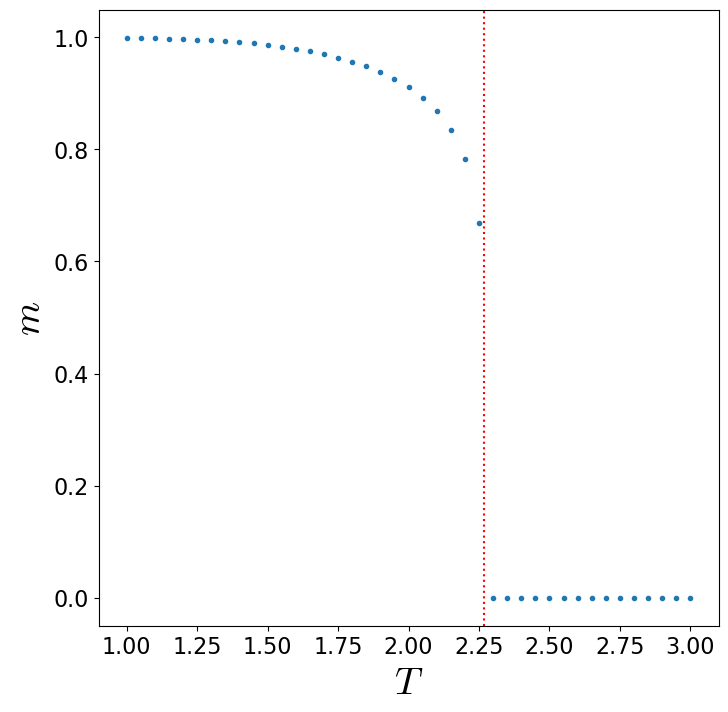

In [9]:
plt.figure(figsize=(8,8))
# plt.plot(T_list,m_list,".")
for i in range(1):
    plt.plot(T_list,m_list[i],".")
plt.xlabel("$T$",fontsize=28)
plt.ylabel("$m$",fontsize=28)
plt.axvline(Ising_Tc,color="red",linestyle=":")

## Calculating the partition function of the Ising model with PBC
Let us first check if our HOTRG scheme can reproduce the exact solution.

Computation of $Z$ is done using cal_lnz_h0(T,D,RG_step) defined above.


In [10]:
def cal_lnz_h0(T,χ,RG_step=20,return_list=False):
    lnz = 0
    area = 4
    A = initialize_Ising(T)
    A_new,_,norm = normalize_tensor(A,A)
    lnz += np.log(norm)/area
    if return_list:
        lnz_list = [lnz] 
    for i in range(RG_step):
        A_new, norm = HOTRG_step(A_new,χ,cutoff=1e-12)
        area *= 4
        lnz += np.log(norm)/area
        if return_list:
            lnz_list.append(lnz)
    if return_list:
        return np.array(lnz_list)
    return lnz

In [11]:
from scipy.integrate import quad
# funciton from Okubo-san's github
# https://github.com/TsuyoshiOkubo/ABTRG/blob/main/TensorNetwork_TRG.py
def Free_Energy_exact_2D_Ising(T):
    import scipy.integrate as integrate    
    def integrant(x,T):
        k = 1.0/np.sinh(2.0/T)**2
        k1 = 2.0*np.sqrt(k)/(1.0+k)
        result = np.log(2*(np.cosh(2.0/T)**2 + (k+1)/k*np.sqrt(1.0-k1**2*np.sin(x)**2)))
        return result

    k = 1.0/np.sinh(2.0/T)**2
    x,err =  integrate.quad(integrant, 0, np.pi*0.5, args=(T,),epsabs=1e-12,epsrel=1e-12)
    result = -T *x/np.pi

    return result,err * T/np.pi

In [12]:
T_list = np.linspace(2.0,2.5,51)
F_TRG = []
F_exact = []
for T in tqdm(T_list):
    F_TRG.append(-T*cal_lnz_h0(T,12,20))
    F_exact.append(Free_Energy_exact_2D_Ising(T)[0])
F_TRG = np.array(F_TRG)
F_exact = np.array(F_exact)

  0%|          | 0/51 [00:00<?, ?it/s]

(1e-07, 1e-05)

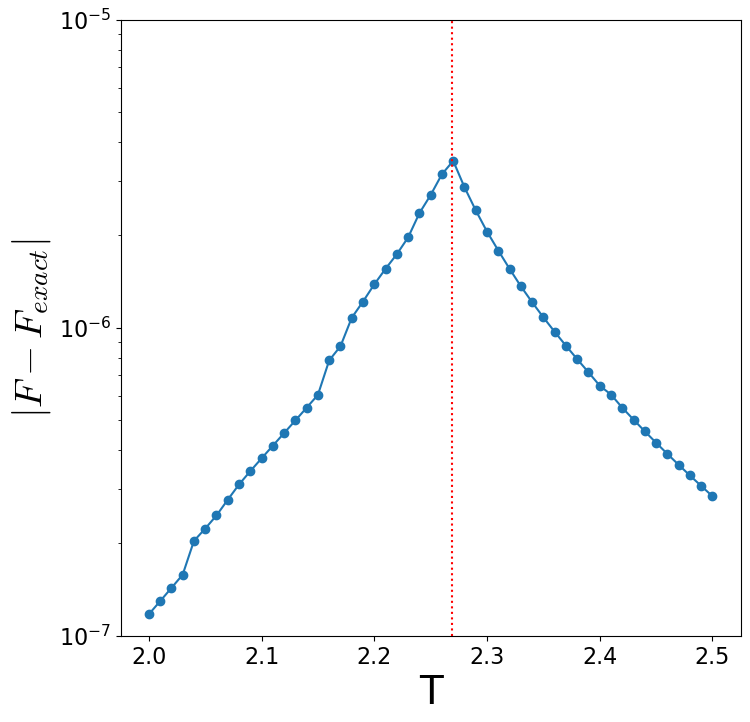

In [13]:
plt.plot(T_list,F_TRG-F_exact,"-o")
plt.xlabel("T")
plt.ylabel("$|F-F_{exact}|$")
plt.yscale("log")
plt.axvline(Ising_Tc,linestyle=":",color="red")
plt.ylim(1e-7,1e-5)